In [13]:
import yfinance as yf
import pypfopt as opt
from pypfopt import plotting
import pandas as pd
import seaborn as sns
import numpy as np

from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt

headers = ['Company name', 'Stock symbol', 'Currency', 'Current price', 'Buy/sell', 'Buy/sell price', 'Qty. shares', 'Buy/sell date', 'Target price', 'Stop loss', 'Country', 'Sector', 'Ghosal sector', 'Weight', 'Standardised current price', 'Standardised buy/sell price', 'P&L', 'Return']

# date will be added to exported file
# today_date = datetime.today().strftime('%Y-%m-%d')

# reading in portfolio spreadsheet as pandas dataframe
df = pd.read_excel('portfolio.xlsx', index_col=False)
df.head()


,Company name,Stock symbol,Currency,Current price,Buy/sell,Buy/sell price,Qty. shares,Buy/sell date,Target price,Stop loss,Country,Sector,Ghosal Sector,Weight,Standardised current price,Standardised buy/sell price,P&L,Return
0,Microsoft Corporation,MSFT,USD,376.17,buy,NaN,1,2023-11-16,NaN,NaN,United States,Technology,NaN,NaN,NaN,NaN,NaN,NaN
1,Caterpillar Inc.,CAT,USD,248.53,buy,NaN,1,2023-11-16,NaN,NaN,United States,Industrials,NaN,NaN,NaN,NaN,NaN,NaN
2,3M Company,MMM,USD,95.57,buy,NaN,1,2023-11-16,NaN,NaN,United States,Industrials,NaN,NaN,NaN,NaN,NaN,NaN
3,McDonald's Corporation,MCD,USD,276.04,buy,NaN,1,2023-11-16,NaN,NaN,United States,Consumer Cyclical,NaN,NaN,NaN,NaN,NaN,NaN
4,"The Goldman Sachs Group, Inc.",GS,USD,336.67,buy,NaN,1,2023-11-16,NaN,NaN,United States,Financial Services,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# parsing data
symbols = df['Stock symbol']
symbols_str = ''.join(symbol + ' ' for symbol in symbols)
latest_prices = df['Current price']

# handles how far back you wanna go. you can also change "years" parameter to "months" if needed and make a new variable months_back
years_back = 5

today_date_raw = datetime.today()
start_date_raw = today_date_raw - relativedelta(years=years_back)
today_date = today_date_raw.strftime('%Y-%m-%d')
start_date = start_date_raw.strftime('%Y-%m-%d')

# downloads historical prices for each stock symbol
prices = yf.download(symbols_str, start=start_date,end=today_date)['Adj Close']
prices

[*********************100%%**********************]  5 of 5 completed


,CAT,GS,MCD,MMM,MSFT
Date,,,,,
2018-12-24,103.538307,138.829498,151.680923,146.070587,89.385567
2018-12-26,110.452667,144.672119,155.021347,152.318405,95.491486
2018-12-27,112.143639,146.874207,156.517883,155.949310,96.080246
2018-12-28,111.205177,144.760895,156.384232,154.861664,95.330048
2018-12-31,112.497765,148.330444,158.174728,155.818420,96.450607
...,...,...,...,...,...
2023-12-15,285.739990,380.510010,287.269989,106.980003,370.730011
2023-12-18,285.709991,376.399994,290.230011,105.870003,372.649994
2023-12-19,292.959991,382.450012,290.730011,106.250000,373.260010


In [15]:
# downloads historical market data from S&P500
# we may want to consider what an appropriate time period is with respect to our historical asset returns, and investment time horizon 
market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices

[*********************100%%**********************]  1 of 1 completed


Date
1993-01-29     24.840668
1993-02-01     25.017345
1993-02-02     25.070353
1993-02-03     25.335381
1993-02-04     25.441383
                 ...    
2023-12-18    471.970001
2023-12-19    474.839996
2023-12-20    468.260010
2023-12-21    472.700012
2023-12-22    473.730103
Name: Adj Close, Length: 7782, dtype: float64

In [16]:
# parameter for market-implied returns vector (prior)
market_caps = {}
for symbol in symbols:
    ticker = yf.Ticker(symbol)
    market_caps[symbol] = ticker.fast_info['marketCap'] 

market_caps

{'MSFT': 2781969258388.5938,
 'CAT': 147868822426.22852,
 'MMM': 58948794410.251465,
 'MCD': 211506902925.48633,
 'GS': 124278020885.74219}

In [17]:

# returns Pandas series - vector
# expected/implied returns needed for optimisation along each efficient frontier

# delta = market-implied risk premium --> excess return/variance
# risk-free rate based on 5y US treasury yield, should reflect time period of returns
delta = opt.black_litterman.market_implied_risk_aversion(market_prices, risk_free_rate=0.0395)
delta

2.0890919512141473

Yield curve
https://markets.ft.com/data/bonds

<Axes: >

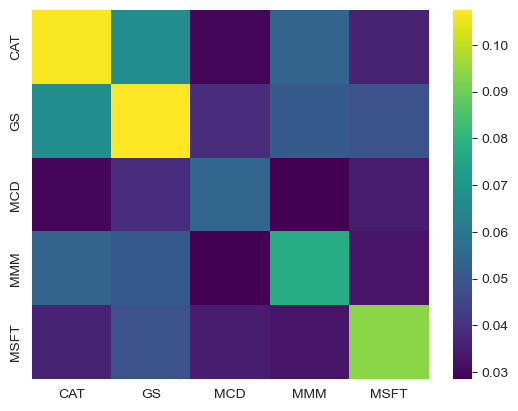

In [22]:

# square covariance matrix made using covariance shrinkage estimator - LW method, const. variance shrinkage
# considering revising whether this is the most appropriate method
Sigma = opt.risk_models.CovarianceShrinkage(prices).ledoit_wolf(shrinkage_target='constant_variance')


# plots correlation using shrinkage estimate covar. matrix
# opt.plotting.plot_covariance(Sigma, plot_correlation=False)

# return_cov = opt.risk_models.sample_cov(prices)
sns.heatmap(Sigma, cmap='viridis')

Covariance matrices based on sample covariance may not accurately reflect the underlying covariance structure of the market, and is sensitive to outliers. Rather than using a sample cov. matrix (unbiased, but poor estimate), we'll fit it to a matrix that's a "shrinkage target" (high bias, but low est. error).

In [19]:
# prior estimate of returns
market_prior = opt.black_litterman.market_implied_prior_returns(market_caps, delta, Sigma)
market_prior

CAT     0.103963
GS      0.126319
MCD     0.094883
MMM     0.092587
MSFT    0.196726
dtype: float64

Overly optimistic expected returns, to be expected given we haven't provided our own views.

<Axes: >

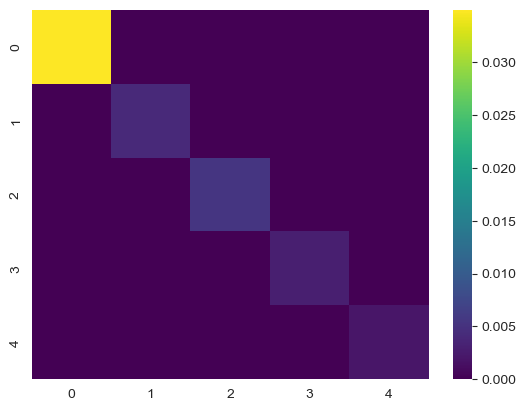

In [25]:
# adding views - forming posterior

view_dict = {
    'MMM': 0.01,
    'MCD': 0.3,
    'GS': 0.07,
    'CAT': 0.23,
    'MSFT': 0.14
}

confidences =[
    0.1,
    0.4,
    0.5,
    0.65,
    0.7
]

bl = opt.BlackLittermanModel(Sigma, pi=market_prior, absolute_views=view_dict, view_confidences=confidences, omega='idzorek')

omega = bl.omega
sns.heatmap(omega, cmap='viridis')


In [0]:
np.diag(omega)


In [26]:
# posterior estimate given views and confidences
posterior = bl.bl_returns()
posterior

CAT     0.175039
GS      0.138818
MCD     0.158242
MMM     0.120563
MSFT    0.174733
dtype: float64

class parameter details
ef = EfficientCVaR(expected_returns(np array), returns(pd df), beta=0.95, weight_bounds=(0,1), solver=None(string, optional), verbose=False, solver_options=None)

EFFICIENT FRONTIER
to plot the entire frontier, pass the EfficientFrontier object into the plotting function BEFORE calling an optimisation function like ef.min_volatility(). it doesn't like it when you don't

note: success plotting efficient frontier with regular EfficientFrontier. EfficientCVaR gives weights but won't let me plot the efficient frontier at all.

In [35]:
# assuming we're using Conditional Value at Risk (CVaR) for efficient frontier
# class methods in efficient_frontier classes return optimal portfolio weights as OrderedDict
ec = opt.EfficientCVaR(posterior, Sigma, weight_bounds=(0, 0.5))

cvar_weights_dict = ec.min_cvar()
ec.portfolio_performance(verbose=True)

latest_prices = prices.iloc[-1]

# here, weights should be an OrderedDict generated by an efficient_frontier class
da = opt.DiscreteAllocation(cvar_weights_dict, latest_prices, total_portfolio_value=15000, short_ratio=None)

# greedy portfolio vs. integer programming
# greedy portfolio: buys as many shares as possible for each asset without going over desired weight, then bin packs the remainder, prioritising assets w/ the biggest diff. between their current weight and ideal weight
# tradeoff between optimal and computational efficiency
allocation, leftover = da.greedy_portfolio()

cvar_weights_array = np.fromiter(cvar_weights_dict.values(), dtype=float)
# std. dev.
portfolio_volatility = np.sqrt(np.dot(cvar_weights_array.transpose(), np.dot(Sigma, cvar_weights_array)))


print(f"Discrete allocation (no. shares): {allocation}")
print(f"Funds remaining: ${leftover:.2f}")
print(f'Portfolio volatility (standard deviation): {portfolio_volatility:.4f}')

Expected annual return: 14.8%
Conditional Value at Risk: -4.33%
Discrete allocation (no. shares): {'MCD': 20, 'GS': 15, 'MMM': 16, 'MSFT': 4}
Funds remaining: $280.53
Portfolio volatility (standard deviation): 0.2313


C:\Users\EYKS\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


<Axes: >

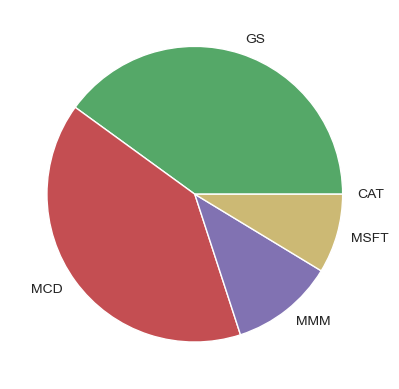

In [37]:
pd.Series(cvar_weights_dict).plot.pie()